In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")



In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
inspector = inspect(engine)
tables = inspector.get_table_names(schema='main')
print(tables)

['measurement', 'station']


In [7]:
columns = {}
for t in tables:    
    cols = inspector.get_columns(t)
    print(f'Table: {t}')
    columns[t] = []
    for c in cols:
        columns[t].append(f'{t}.{c["name"]}')
        print('Column: ',c['name'], c["type"])


Table: measurement
Column:  id INTEGER
Column:  station TEXT
Column:  date TEXT
Column:  prcp FLOAT
Column:  tobs FLOAT
Table: station
Column:  id INTEGER
Column:  station TEXT
Column:  name TEXT
Column:  latitude FLOAT
Column:  longitude FLOAT
Column:  elevation FLOAT


In [8]:
# Save references to each table
measurement = Base.classes.measurement
station =  Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

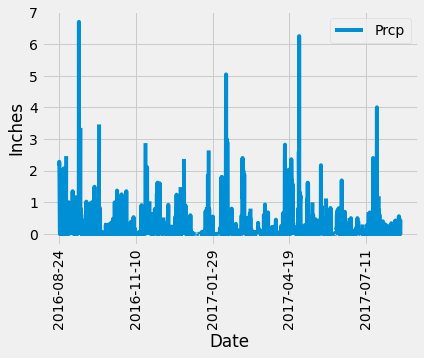

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
newest = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
# Calculate the date one year from the last date in data set.
oneYearLess = dt.datetime.strptime(newest, '%Y-%m-%d')-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data_ly =session.query(measurement.date, measurement.prcp).filter(measurement.date > oneYearLess).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data_ly_df = pd.DataFrame(data_ly,columns={'Prcp','Date'})

# Sort the dataframe by date
data_ly_df =data_ly_df.set_index('Date').sort_index()
data_ly_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
data_ly_df.plot()
plt.xticks(rotation="vertical")
plt.ylabel('Inches')
plt.legend()
plt.savefig('Images/precipitation.png',bbox_inches='tight')



In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_ly_df.describe()

,Prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count( measurement.station)).all()


[(19550,)]

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(measurement.station,func.count(measurement.station)).\
    group_by(measurement.station).\
        order_by(func.count(measurement.station).desc()).\
            first()


('USC00519281', 2772)

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel =[func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]
session.query(*sel).\
    filter(measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

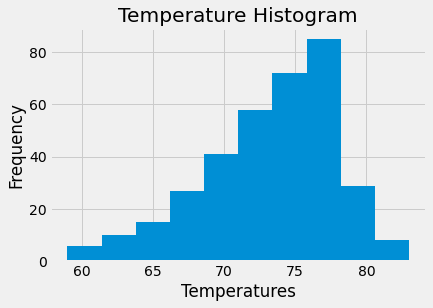

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp12m = session.query(measurement.tobs).\
    filter(measurement.date > oneYearLess).\
        filter(measurement.station == 'USC00519281').all()
temp12m_df = pd.DataFrame(temp12m,columns={'temp'})['temp'].astype(int)
temp12m_df.plot(kind='hist')
plt.title('Temperature Histogram')
plt.xlabel('Temperatures')
plt.savefig('Images/station-histogram.png',bbox_inches='tight')




# Close session

In [ ]:
# Close Session
session.close()